In [1]:
import numpy as np
import pandas as pd 
import warnings
import pickle
import wandb
import time
import tqdm

In [2]:
your_sweep_ids = [
    'mawmzi1z', # sine init
    '0ne6vy3t', # mnist init
]

In [3]:
api = wandb.Api(timeout=60)
entity, project = 'the-real-dl', 'bio-transformers'

In [4]:
def extract(wandb_sweeps, maxrun=None):
    
    dfs = []
    count = 0

    for sid in wandb_sweeps:

        for i, run in enumerate(api.sweep(entity + '/' + project + '/' + sid).runs):
            # time.sleep(2) # to avoid 429 Client Error
            print(f'Fetching run #{i} ({run.sweep.name} - {run.id} - {run.state})'.ljust(100), end='\r')
            if maxrun is not None and count == maxrun: break

            summary = run.summary
            if not 'epoch' in summary.keys(): continue
            if run.state == 'running': continue
            if run.state == 'crashed': continue
            if run.state == 'failed': continue

            run_id = run.id
            sweep_id = run.sweep.id

            config = run.config
            run_df = run.history(samples=run.config['epochs'] * 4)

            config.update({'sweep-id': sweep_id, 'run-id': run_id})
            summary.update({'sweep-id': sweep_id, 'run-id': run_id})

            l_epochs = []
            l_train_loss = []
            l_test_loss = []
            l_train_energy = []
            l_gen_error = []

            for e in range(summary['epoch']):
                x = run_df[run_df.epoch == e]

                train_losses = x.train_loss.unique()
                test_losses = x.test_loss.unique()

                train_loss_no_nan = train_losses[~np.isnan(train_losses)]
                test_loss_no_nan = test_losses[~np.isnan(test_losses)]

                train_loss = train_loss_no_nan[0] if len(train_loss_no_nan) > 0 else np.nan
                test_loss = test_loss_no_nan[0] if len(test_loss_no_nan) > 0 else np.nan

                l_epochs.append(e)
                l_train_loss.append(train_loss)
                l_test_loss.append(test_loss)

                gen_errors = x.gen_error.unique()
                gen_error_no_nan = gen_errors[~np.isnan(gen_errors)]
                gen_error = gen_error_no_nan[0] if len(gen_error_no_nan) > 0 else np.nan
                l_gen_error.append(gen_error)

                if config['training'] == 'pc':
                    train_energies = x.train_energy.unique()
                    train_energy_no_nan = train_energies[~np.isnan(train_energies)]
                    train_energy = train_energy_no_nan[0] if len(train_energy_no_nan) > 0 else np.nan
                    l_train_energy.append(train_energy)

                if config['training'] == 'bp':
                    run_ids = np.full(len(l_epochs), run_id)
                    sweep_ids = np.full(len(l_epochs), sweep_id)
                    data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss, l_gen_error))
                    columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss', 'gen_error']
                else:
                    run_ids = np.full(len(l_epochs), run_id)
                    sweep_ids = np.full(len(l_epochs), sweep_id)
                    data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss, l_train_energy, l_gen_error))
                    columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss', 'train_energy', 'gen_error']

            df = pd.DataFrame(data, columns=columns)

            # adding configs to df
            for k in list(config.keys())[:-2]:
                df['c_' + str(k)] = config[k]

            # adding summary to df
            for k in summary.keys():
                if k in ['_runtime', 'train_loss', 'test_loss', 'train_energy', 'gen_error']:
                    df['f_' + str(k)] = summary[k]

            dfs.append(df)
            count += 1

    print(f'Fetched {count} runs in {entity}/{project} (max runs: {"all" if maxrun is None else maxrun})'.ljust(100))
    return pd.concat(dfs, axis=0).reset_index(drop=True)

In [24]:
def init_stats(df, merge_ds=True):
    if merge_ds: df = df.groupby(['c_pc_init']).agg({'f_gen_error': np.min, 'f_test_loss': np.min})
    else: df = df.groupby(['c_pc_init', 'c_dataset']).agg({'f_gen_error': np.min, 'f_test_loss': np.min})
    return df.reset_index().sort_values('f_gen_error', ascending=True)

In [28]:
def median_over_seeds(df):
    infos = df[['sweep_id', 'c_dataset', 'c_training']].drop_duplicates().set_index('sweep_id').to_dict()
    df = df.drop(columns=[c for c in list(df.columns) if c.startswith('c') and c != 'c_pc_init'])
    df = df.groupby(['sweep_id', 'c_pc_init', 'epoch']).agg(np.median).reset_index()
    for k in infos.keys(): df[k] = df.apply(lambda r: infos[k][r.sweep_id], axis=1)
    return df

In [44]:
def plot_init(df):
    assert len(df.sweep_id.unique()) == 1
    title = f'{df.c_training.unique()[0]} {df.c_dataset.unique()[0]} initialization (median over seeds)'

    df_init_fwd = df[df.c_pc_init == 'forward'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
    df_init_zeros = df[df.c_pc_init == 'zeros'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
    df_init_xavier = df[df.c_pc_init == 'xavier_normal'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
    df_init_normal = df[df.c_pc_init == 'normal'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')

    filt = lambda ls: (ls > np.quantile(ls, 0.01)) & (ls < np.quantile(ls, 0.99))
    df_init_fwd = df_init_fwd[filt(df_init_fwd.gen_error)]
    df_init_zeros = df_init_zeros[filt(df_init_zeros.gen_error)]
    df_init_xavier = df_init_xavier[filt(df_init_xavier.gen_error)]
    df_init_normal = df_init_normal[filt(df_init_normal.gen_error)]

    ax = df_init_fwd.plot(x='epoch', y='gen_error', label=f'OOD Error (forward)', figsize=(10,4), title=title)
    ax = df_init_zeros.plot(x='epoch', y='gen_error', label=f'OOD Error (zeros)', ax=ax, figsize=(10,4))
    ax = df_init_xavier.plot(x='epoch', y='gen_error', label=f'OOD Error (xavier)', ax=ax, figsize=(10,4))
    ax = df_init_normal.plot(x='epoch', y='gen_error', label=f'OOD Error (normal)', ax=ax, figsize=(10,4))

In [7]:
df = extract(your_sweep_ids, maxrun=None)
df_med = median_over_seeds(df)

Fetched 36 runs in the-real-dl/bio-transformers (max runs: all)                                     


In [34]:
df_init_sine = df_med[df_med.sweep_id == 'mawmzi1z']
df_init_mnist = df_med[df_med.sweep_id == '0ne6vy3t']

In [25]:
init_stats(df, merge_ds=True)

,c_pc_init,f_gen_error,f_test_loss
0,forward,0.162269,0.034391
3,zeros,0.238972,0.205676
2,xavier_normal,0.247099,0.207275
1,normal,0.353875,0.335349


In [30]:
init_stats(df, merge_ds=False)

,c_pc_init,c_dataset,f_gen_error,f_test_loss
1,forward,sine,0.162269,0.034391
7,zeros,sine,0.238972,0.205676
5,xavier_normal,sine,0.247099,0.207275
3,normal,sine,0.353875,0.335349
0,forward,mnist,1.717192,0.076926
2,normal,mnist,2.302526,2.302528
4,xavier_normal,mnist,2.302564,2.302565
6,zeros,mnist,2.302573,2.302572


In [40]:
df_init_fwd = df[df.c_pc_init == 'forward'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
df_init_zeros = df[df.c_pc_init == 'zeros'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
df_init_xavier = df[df.c_pc_init == 'xavier_normal'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')
df_init_normal = df[df.c_pc_init == 'normal'][['epoch', 'train_loss', 'test_loss', 'gen_error']].reset_index(drop=True).fillna(method='ffill')    

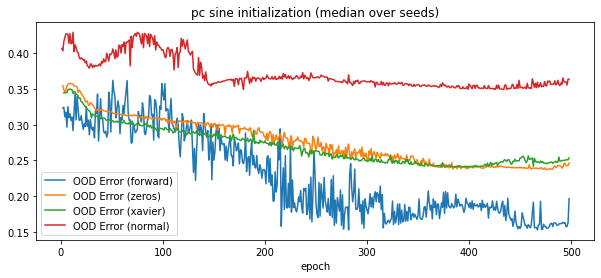

In [45]:
plot_init(df_init_sine)

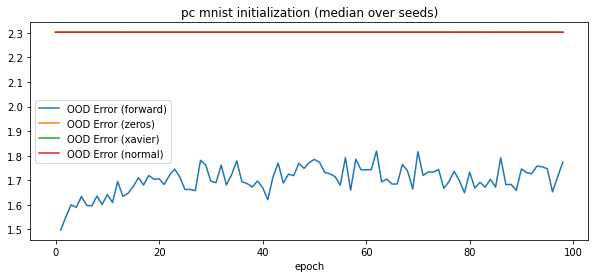

In [46]:
plot_init(df_init_mnist)